In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [54]:
# Calculate moving averages
def moving_average(data, span):
    return data['Close'].ewm(span=span, adjust=False).mean()
    #nreturn data['Close'].rolling(window=window).mean()

In [55]:
def exponential_moving_average(data, span):
    return data['Close'].ewm(span=span, adjust=False).mean()

In [56]:
# Calculate momentum
def momentum(data, window):
    return data['Close'].diff(window - 1)

In [57]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()

    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss

    rsi = 100 - (100 / (1 + rs))

    return rsi

In [58]:
def adx(data, window=14):

    # Calculate True Range
    data['tr0'] = abs(data['High'] - data['Low'])
    data['tr1'] = abs(data['High'] - data['Close'].shift())
    data['tr2'] = abs(data['Low'] - data['Close'].shift())
    data['TR'] = data[['tr0', 'tr1', 'tr2']].max(axis=1)

    # Calculate Directional Movement
    data['DMplus'] = np.where((data['High'] - data['High'].shift()) > (data['Low'].shift() - data['Low']), data['High'] - data['High'].shift(), 0)
    data['DMminus'] = np.where((data['Low'].shift() - data['Low']) > (data['High'] - data['High'].shift()), data['Low'].shift() - data['Low'], 0)

    # Calculate Smoothed True Range
    data['ATR'] = data['TR'].rolling(window=window).mean()

    # Calculate Smoothed Directional Movement
    data['ADMplus'] = data['DMplus'].rolling(window=window).mean()
    data['ADMminus'] = data['DMminus'].rolling(window=window).mean()

    # Calculate Directional Index
    data['DIplus'] = (data['ADMplus'] / data['ATR']) * 100
    data['DIminus'] = (data['ADMminus'] / data['ATR']) * 100

    data['DX'] = abs(data['DIplus'] - data['DIminus']) / (data['DIplus'] + data['DIminus']) * 100

    adx_values = data['DX'].rolling(window=window).mean()

    return (adx_values, data['DIplus'], data['DIminus'])

In [158]:
# Trading strategy combining moving average crossover, momentum, and VWAP
def trading_strategy(data, complete=False, rsi_window=None, overbought_threshold=None, oversold_threshold=None, adx_window=None, adx_threshold=None, short_window=None, long_window=None):
    signals = pd.DataFrame(index=data.index)
    signals['Date'] = pd.to_datetime(data['Date'])
    signals['signal'] = 0.0

        
    # Moving average crossover
    if short_window:
        signals['short_mavg'] = moving_average(data, short_window)
        signals['long_mavg'] = moving_average(data, long_window)
        signals['signal_ma'] = 0.0
        # Place buy order when short moving average crosses above long moving average
        signals.loc[(signals['short_mavg'].shift(1) < signals['long_mavg'].shift(1)) & (signals['short_mavg'] > signals['long_mavg']), 'signal_ma'] = 1.0

        # Place sell order when short moving average crosses below long moving average
        signals.loc[(signals['short_mavg'].shift(1) > signals['long_mavg'].shift(1)) & (signals['short_mavg'] < signals['long_mavg']), 'signal_ma'] = -1.0
        
    if rsi_window:
        rsi_values = calculate_rsi(data, window=rsi_window)
        signals['signal_rsi'] = 0.0
        signals['rsi'] = rsi_values
        signals.loc[signals['rsi'] > overbought_threshold, 'signal_rsi'] = -1.0
        signals.loc[signals['rsi'] < oversold_threshold, 'signal_rsi'] = 1.0

    if adx_window:
        adx_values = adx(data, window=adx_window)
        signals['signal_adx'] = 0.0
        signals['adx'] = adx_values[0]
        signals['+DI'] = adx_values[1]
        signals['-DI'] = adx_values[2]
        signals.loc[(signals['+DI'].shift(1) < signals['-DI'].shift(1)) & (signals['+DI'] > signals['-DI']) & (signals['adx'] > adx_threshold), 'signal_adx'] = 1.0
    
        # Place sell signal when -DI crosses over +DI and ADX is above the threshold
        signals.loc[(signals['+DI'].shift(1) > signals['-DI'].shift(1)) & (signals['+DI'] < signals['-DI']) & (signals['adx'] > adx_threshold), 'signal_adx'] = -1.0
        
        
    if complete:
        signals_sum = signals['signal_ma'] + signals['signal_rsi'] + signals['signal_adx']
        signals['sum'] = signals_sum
        signals['signal'] = 0.0
        signals.loc[signals['sum'] >= 2.0, 'signal'] = 1.0
        signals.loc[signals['sum'] <= -2.0, 'signal'] = -1.0
            
    elif short_window:
        signals['signal'] = signals['signal_ma']
    elif rsi_window:
        signals['signal'] = signals['signal_rsi']
    elif adx_window:
        signals['signal'] = signals['signal_adx']
    return signals

In [159]:
df = pd.read_csv("MSFT_hist.csv")
df = df[df['Date'] >= '2019-01-01']

In [160]:
signals = trading_strategy(df, short_window=20, long_window=70)
signals.to_csv("MSFT_signal_ma.csv")
signals = trading_strategy(df, adx_window=14, adx_threshold=25)
signals.to_csv("MSFT_signal_adx.csv")
signals = trading_strategy(df, rsi_window=14, overbought_threshold=70, oversold_threshold=50)
signals.to_csv("MSFT_signal_rsi.csv")
signals = trading_strategy(df, complete=True, short_window=10, long_window=11, adx_window=14, adx_threshold=25, rsi_window=14, overbought_threshold=70, oversold_threshold=50)
signals.to_csv("MSFT_complete_signal.csv")

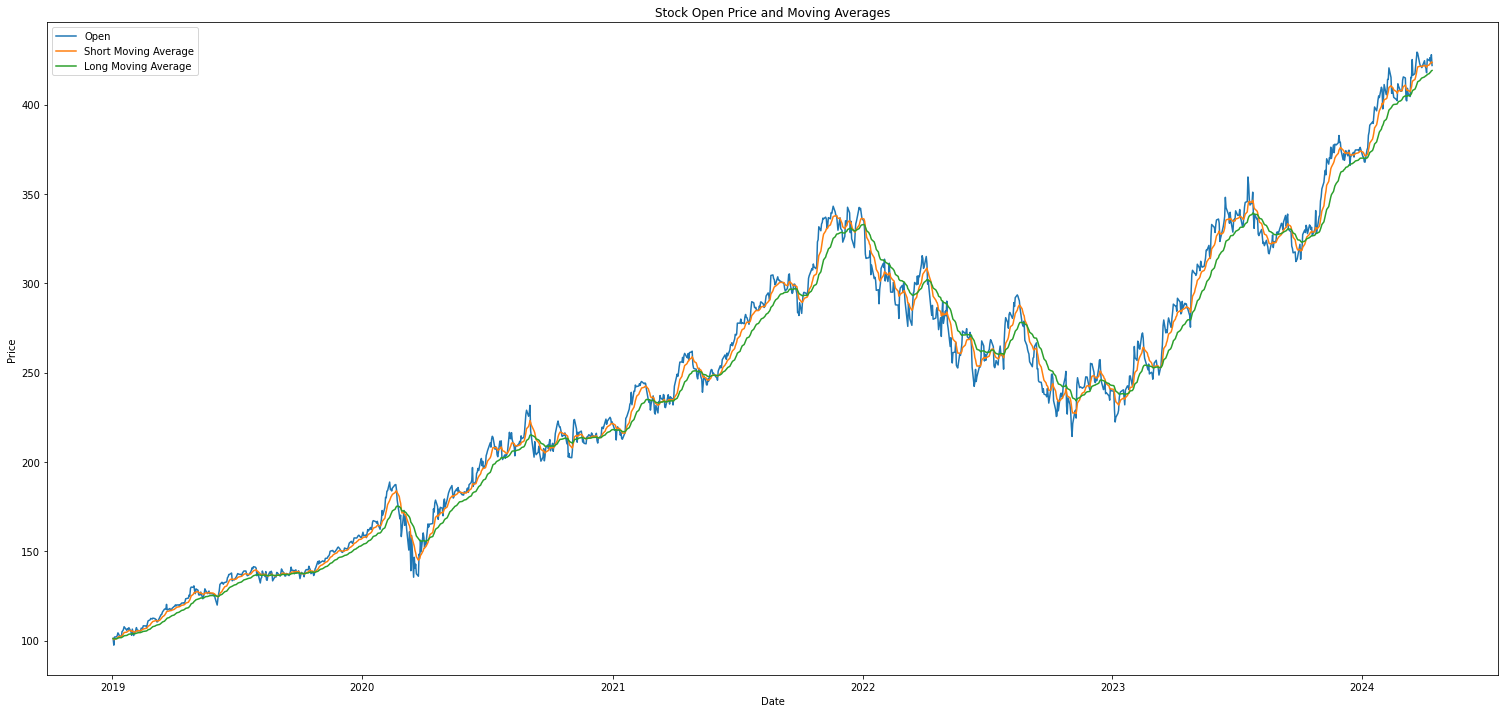

In [157]:
# Plotting the graph
plt.figure(figsize=(26, 12))
plt.plot(signals['Date'].values, df['Close'].values, label='Open')
plt.plot(signals['Date'].values, signals['short_mavg'].values, label='Short Moving Average')
plt.plot(signals['Date'].values, signals['long_mavg'].values, label='Long Moving Average')
plt.title('Stock Open Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

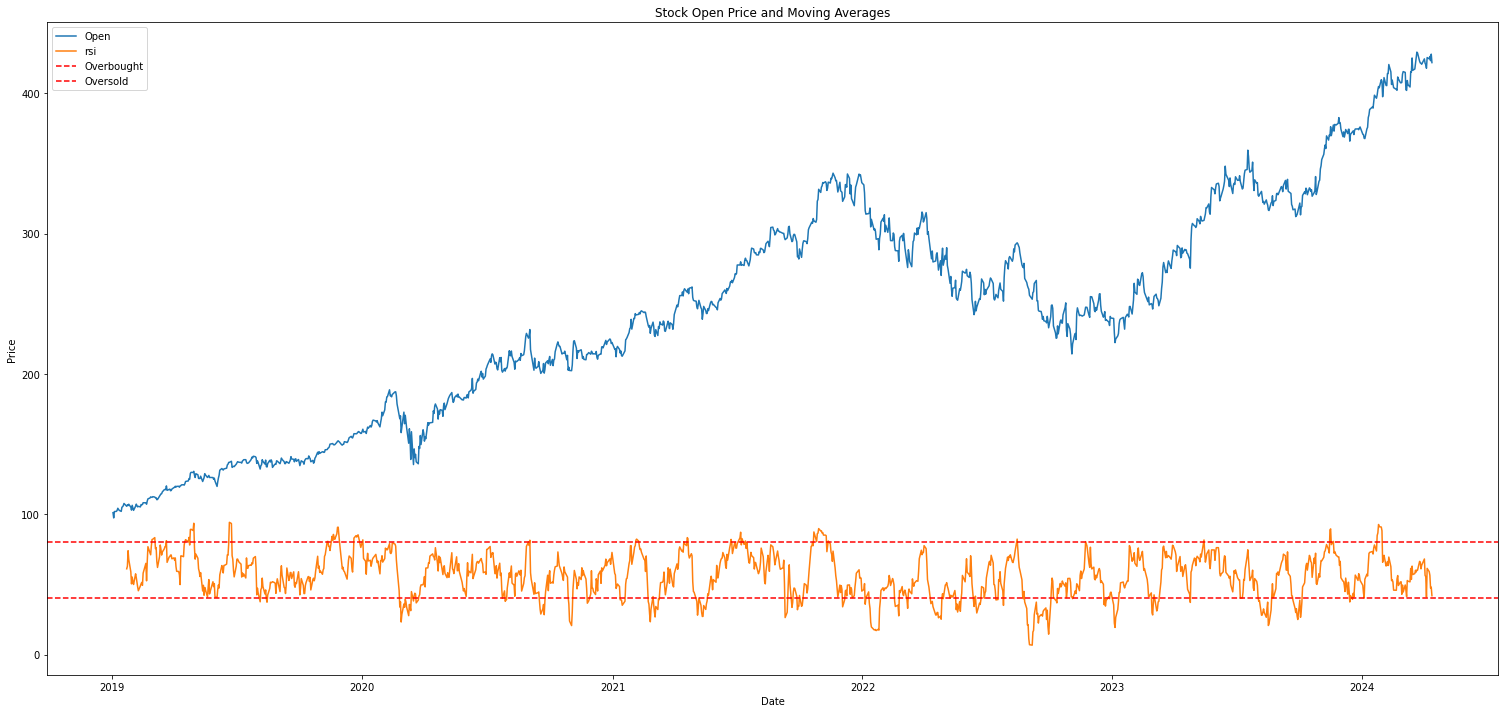

In [161]:
# Plotting the graph
plt.figure(figsize=(26, 12))
plt.plot(signals['Date'].values, df['Close'].values, label='Open')
plt.plot(signals['Date'].values, signals['rsi'].values, label='rsi')
plt.axhline(y=80, color='r', linestyle='--', label='Overbought')
plt.axhline(y=40, color='r', linestyle='--', label='Oversold')
plt.title('Stock Open Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

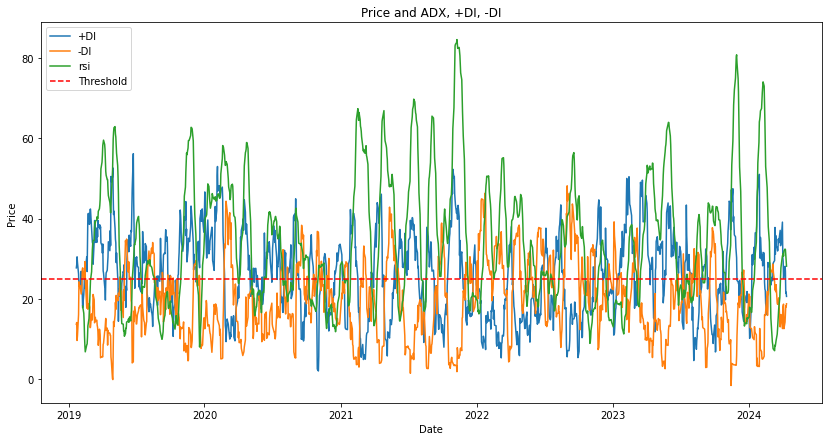

In [162]:
plt.figure(figsize=(14, 7))
plt.plot(signals['Date'].values, signals['+DI'].values, label='+DI')
plt.plot(signals['Date'].values, signals['-DI'].values, label='-DI')
plt.plot(signals['Date'].values, signals['adx'].values, label='rsi')
plt.axhline(y=25, color='r', linestyle='--', label='Threshold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price and ADX, +DI, -DI')
plt.legend()
plt.show()

In [236]:

def backtest_strategy(data, initial_cash, transaction_cost, stop_loss, take_profit, **kwargs):
    signals = trading_strategy(data, **kwargs)

    # Initialize portfolio
    portfolio = pd.DataFrame(index=signals.index)
    portfolio['Cash'] = initial_cash
    portfolio['Position'] = 0.0
    portfolio['pnl'] = 0
    portfolio['g_sl'] = 0
    portfolio['g_tp'] = 0
    portfolio['close'] = 0
    portfolio['amount'] = 0
    portfolio['multiplier'] = 0
    portfolio['Cash'] = portfolio['Cash'].astype(float)
    portfolio['Position'] = portfolio['Position'].astype(float)
    portfolio['pnl'] = portfolio['pnl'].astype(float)
    portfolio['g_sl'] = portfolio['g_sl'].astype(float)
    portfolio['g_tp'] = portfolio['g_tp'].astype(float)
    portfolio['close'] = portfolio['close'].astype(float)
    portfolio['amount'] = portfolio['amount'].astype(float)
    portfolio['multiplier'] = portfolio['multiplier'].astype(float)
    global sl, tp, buy, sell, amount, pnl, no_trades, no_wins, multiplier
    sl = 0
    tp = 0
    buy = False
    sell = False
    pnl = 0
    amount = 0
    no_trades = 0
    no_wins = 0
    multiplier = 0
    
    cash_balance = initial_cash  # Initialize cash balance
    
    for index, row in signals.iterrows():
        signal = row['signal']
        price = data.loc[index, 'Close']
        stop_loss_price = price - (stop_loss * price)
        take_profit_price = price + (take_profit * price)
        
        
        if signal == 1.0 and cash_balance >= price * multiplier and tp == 0:
            # Buy
            amount = price
            multiplier = round(cash_balance/amount, 2)
            portfolio.loc[index, 'Position'] = 1.0
            cash_balance -= price * multiplier
            tp = take_profit_price
            sl = stop_loss_price
            buy = True
        elif signal == -1.0 and cash_balance >= price * multiplier and tp == 0:
            # Sell
            amount = price
            multiplier = round(cash_balance/amount, 2)
            portfolio.loc[index, 'Position'] = -1.0
            cash_balance -= price * multiplier
            tp = stop_loss_price
            sl = take_profit_price
            sell = True
        
        if price >= tp and buy:
            cash_balance += (amount*multiplier) + ((tp - amount)*multiplier)
            tp = 0
            sl = 0
            amount = 0
            buy = False
            no_trades += 1
            no_wins += 1
            multiplier = 0
        if price <= sl and buy:
            cash_balance += (amount*multiplier) + ((sl - amount)*multiplier)
            tp = 0
            sl = 0
            amount = 0
            buy = False
            no_trades += 1
            multiplier = 0
        if price <= tp and sell:
            cash_balance += (amount*multiplier) + ((amount - tp)*multiplier)
            tp = 0
            sl = 0
            amount = 0
            sell = False
            no_trades += 1
            no_wins += 1
            multiplier = 0
        if price >= sl and sell:
            cash_balance += (amount*multiplier) + ((amount - sl)*multiplier)
            tp = 0
            sl = 0
            amount = 0
            sell = False
            no_trades += 1
            multiplier = 0
            
        if index == signals.index[-1] and buy:
            cash_balance += (amount*multiplier) + ((price - amount)*multiplier)
        elif index == signals.index[-1] and sell:
            cash_balance += (amount*multiplier) + ((amount - price)*multiplier)
            
        pnl = cash_balance - initial_cash
        
        # Update portfolio value
        portfolio.loc[index, 'Cash'] = round(cash_balance, 2)
        portfolio.loc[index, 'amount'] = round(amount, 2)
        portfolio.loc[index, 'pnl'] = round(pnl, 2)
        portfolio.loc[index, 'g_sl'] = round(sl, 2)
        portfolio.loc[index, 'g_tp'] = round(tp, 2)
        portfolio.loc[index, 'close'] = round(price, 2)
        portfolio.loc[index, 'multiplier'] = round(multiplier, 2)
        portfolio.loc[index, 'no_trades'] = int(no_trades)
        portfolio.loc[index, 'no_wins'] = int(no_wins)

    sl = 0
    tp = 0
    pnl = 0
    amount = 0

    return portfolio

def win_percentage(portfolio):
    no_wins = portfolio.iloc[-1]['no_wins']
    no_trades = portfolio.iloc[-1]['no_trades']
    if no_trades == 0:
        return 0
    else:
        return round((no_wins / no_trades) * 100, 2)

In [239]:
# Microsoft
df = pd.read_csv("MSFT_hist.csv")
df = df[df['Date'] >= '2015-01-01']

print("Microsoft")
print("\nMoving Average:")
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, short_window=10, long_window=20, stop_loss=0.05, take_profit=0.05)
print("Short-Window: 10, Long-Window: 20, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, short_window=10, long_window=30, stop_loss=0.05, take_profit=0.05)
print("Short-Window: 10, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, short_window=10, long_window=50, stop_loss=0.05, take_profit=0.05)
print("Short-Window: 10, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, short_window=20, long_window=30, stop_loss=0.05, take_profit=0.05)
print("Short-Window: 20, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, short_window=20, long_window=50, stop_loss=0.05, take_profit=0.05)
print("Short-Window: 20, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, short_window=20, long_window=70, stop_loss=0.05, take_profit=0.05)
print("Short-Window: 20, Long-Window: 70, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, short_window=20, long_window=100, stop_loss=0.05, take_profit=0.05)
print("Short-Window: 20, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, short_window=30, long_window=100, stop_loss=0.05, take_profit=0.05)
print("Short-Window: 30, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, short_window=40, long_window=100, stop_loss=0.05, take_profit=0.05)
print("Short-Window: 40, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nADX:")
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, adx_window=4, adx_threshold=50, stop_loss=0.05, take_profit=0.05)
print("ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, adx_window=4, adx_threshold=75, stop_loss=0.05, take_profit=0.05)
print("ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, adx_window=6, adx_threshold=25, stop_loss=0.05, take_profit=0.05)
print("ADX-Window: 6, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, adx_window=6, adx_threshold=50, stop_loss=0.05, take_profit=0.05)
print("ADX-Window: 6, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, adx_window=6, adx_threshold=75, stop_loss=0.05, take_profit=0.05)
print("ADX-Window: 6, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, adx_window=10, adx_threshold=25, stop_loss=0.05, take_profit=0.05)
print("ADX-Window: 10, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, adx_window=10, adx_threshold=50, stop_loss=0.05, take_profit=0.05)
print("ADX-Window: 10, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, adx_window=10, adx_threshold=75, stop_loss=0.05, take_profit=0.05)
print("ADX-Window: 10, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, adx_window=14, adx_threshold=25, stop_loss=0.05, take_profit=0.05)
print("ADX-Window: 14, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, adx_window=14, adx_threshold=50, stop_loss=0.05, take_profit=0.05)
print("ADX-Window: 14, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, adx_window=14, adx_threshold=75, stop_loss=0.05, take_profit=0.05)
print("ADX-Window: 14, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, adx_window=18, adx_threshold=25, stop_loss=0.05, take_profit=0.05)
print("ADX-Window: 18, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, adx_window=18, adx_threshold=50, stop_loss=0.05, take_profit=0.05)
print("ADX-Window: 18, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, adx_window=18, adx_threshold=75, stop_loss=0.05, take_profit=0.05)
print("ADX-Window: 18, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nRSI:")
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 10, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 10, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 10, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 10, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 10, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 10, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 10, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 10, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 10, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 14, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 14, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 14, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 14, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 14, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 14, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 14, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 14, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 14, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 18, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 18, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 18, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 18, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 18, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 18, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 18, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 18, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 18, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=26, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 26, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, rsi_window=100, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
print("RSI-Window: 100, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nComplete:")
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.10)
print("Complete Fast, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio.to_csv("MSFT_portfolio.csv")
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=22, adx_threshold=40, rsi_window=70, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.10)
print("Complete Normal, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=1000, transaction_cost=0, complete=True, short_window=20, long_window=50, adx_window=30, adx_threshold=60, rsi_window=70, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.10)
print("Complete Slow, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))


Microsoft

Moving Average:
Short-Window: 10, Long-Window: 20, Total Profit/Loss: -430.63 , No-Trades: 50.0  Win%: 40.0
Short-Window: 10, Long-Window: 30, Total Profit/Loss: -182.45 , No-Trades: 41.0  Win%: 46.34
Short-Window: 10, Long-Window: 50, Total Profit/Loss: -414.59 , No-Trades: 28.0  Win%: 32.14
Short-Window: 20, Long-Window: 30, Total Profit/Loss: -352.97 , No-Trades: 28.0  Win%: 35.71
Short-Window: 20, Long-Window: 50, Total Profit/Loss: -163.77 , No-Trades: 23.0  Win%: 43.48
Short-Window: 20, Long-Window: 70, Total Profit/Loss: -317.04 , No-Trades: 25.0  Win%: 36.0
Short-Window: 20, Long-Window: 100, Total Profit/Loss: -113.07 , No-Trades: 16.0  Win%: 43.75
Short-Window: 30, Long-Window: 100, Total Profit/Loss: 34.39 , No-Trades: 13.0  Win%: 53.85
Short-Window: 40, Long-Window: 100, Total Profit/Loss: 39.47 , No-Trades: 9.0  Win%: 55.56

ADX:
ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss: -485.38 , No-Trades: 91.0  Win%: 43.96
ADX-Window: 4, ADX-Threshold: 75, Total Pr

In [222]:
# Apple
df = pd.read_csv("AAPL_hist.csv")
df = df[df['Date'] >= '2015-01-01']

print("Apple")
print("\nMoving Average:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=20, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 20, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=30, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=50, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=30, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=50, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=70, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 70, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nADX:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=4, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=4, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nRSI:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=26, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 26, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=100, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 100, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nComplete:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=8)
print("Complete Fast, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=22, adx_threshold=40, rsi_window=70, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=8)
print("Complete Normal, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=20, long_window=50, adx_window=30, adx_threshold=60, rsi_window=70, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=8)
print("Complete Slow, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio.to_csv("AAPL_portfolio.csv")

Apple

Moving Average:
Short-Window: 10, Long-Window: 20, Total Profit/Loss: 157.72 , No-Trades: 1.0  Win%: 100.0
Short-Window: 10, Long-Window: 30, Total Profit/Loss: 158.69 , No-Trades: 1.0  Win%: 100.0
Short-Window: 10, Long-Window: 50, Total Profit/Loss: 162.7 , No-Trades: 1.0  Win%: 100.0


KeyboardInterrupt: 

In [184]:
# JP Morgan
df = pd.read_csv("JPM_hist.csv")
df = df[df['Date'] >= '2015-01-01']

print("JP Morgan")
print("\nMoving Average:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=20, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 20, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=30, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=50, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=30, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=50, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=70, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 70, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=30, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 30, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=40, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 40, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nADX:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=4, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=4, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nRSI:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=26, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 26, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=100, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 100, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nComplete:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=8)
print("Complete Fast, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=22, adx_threshold=40, rsi_window=70, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=8)
print("Complete Normal, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=20, long_window=50, adx_window=30, adx_threshold=60, rsi_window=70, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=8)
print("Complete Slow, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio.to_csv("JPM_portfolio.csv")

JP Morgan

Moving Average:
Short-Window: 10, Long-Window: 20, Total Profit/Loss: 0.0 , No-Trades: 66.0  Win%: 50.0
Short-Window: 10, Long-Window: 30, Total Profit/Loss: 20.0 , No-Trades: 51.0  Win%: 54.9
Short-Window: 10, Long-Window: 50, Total Profit/Loss: 8.0 , No-Trades: 38.0  Win%: 52.63
Short-Window: 20, Long-Window: 30, Total Profit/Loss: -16.0 , No-Trades: 44.0  Win%: 45.45
Short-Window: 20, Long-Window: 50, Total Profit/Loss: -40.0 , No-Trades: 34.0  Win%: 35.29
Short-Window: 20, Long-Window: 70, Total Profit/Loss: -56.0 , No-Trades: 30.0  Win%: 26.67
Short-Window: 20, Long-Window: 100, Total Profit/Loss: 4.0 , No-Trades: 25.0  Win%: 52.0
Short-Window: 30, Long-Window: 100, Total Profit/Loss: -8.0 , No-Trades: 24.0  Win%: 45.83
Short-Window: 40, Long-Window: 100, Total Profit/Loss: -32.0 , No-Trades: 20.0  Win%: 30.0

ADX:
ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss: 60.0 , No-Trades: 101.0  Win%: 57.43
ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss: 8.0 , No-Trade

In [185]:
# Bank of America
df = pd.read_csv("BAC_hist.csv")
df = df[df['Date'] >= '2015-01-01']

print("Bank of America")
print("\nMoving Average:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=20, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 20, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=30, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=50, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=30, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=50, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=70, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 70, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=30, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 30, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=40, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 40, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nADX:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=4, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=4, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nRSI:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=26, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 26, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=100, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 100, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nComplete:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=8)
print("Complete Fast, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=22, adx_threshold=40, rsi_window=70, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=8)
print("Complete Normal, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=20, long_window=50, adx_window=30, adx_threshold=60, rsi_window=70, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=8)
print("Complete Slow, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio.to_csv("BAC_portfolio.csv")

Bank of America

Moving Average:
Short-Window: 10, Long-Window: 20, Total Profit/Loss: 4.0 , No-Trades: 21.0  Win%: 52.38
Short-Window: 10, Long-Window: 30, Total Profit/Loss: 8.0 , No-Trades: 16.0  Win%: 56.25
Short-Window: 10, Long-Window: 50, Total Profit/Loss: -4.0 , No-Trades: 15.0  Win%: 46.67
Short-Window: 20, Long-Window: 30, Total Profit/Loss: 4.0 , No-Trades: 15.0  Win%: 53.33
Short-Window: 20, Long-Window: 50, Total Profit/Loss: -8.0 , No-Trades: 16.0  Win%: 43.75
Short-Window: 20, Long-Window: 70, Total Profit/Loss: -4.0 , No-Trades: 15.0  Win%: 46.67
Short-Window: 20, Long-Window: 100, Total Profit/Loss: -4.0 , No-Trades: 13.0  Win%: 46.15
Short-Window: 30, Long-Window: 100, Total Profit/Loss: 8.0 , No-Trades: 12.0  Win%: 58.33
Short-Window: 40, Long-Window: 100, Total Profit/Loss: 0.0 , No-Trades: 12.0  Win%: 50.0

ADX:
ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss: -12.0 , No-Trades: 27.0  Win%: 44.44
ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss: 4.0 , No-Tr

In [186]:
# Pfizer
df = pd.read_csv("PFE_hist.csv")
df = df[df['Date'] >= '2015-01-01']

print("Pfizer")
print("\nMoving Average:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=20, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 20, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=30, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=50, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=30, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=50, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=70, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 70, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=30, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 30, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=40, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 40, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nADX:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=4, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=4, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nRSI:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=26, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 26, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=100, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 100, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nComplete:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=8)
print("Complete Fast, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=22, adx_threshold=40, rsi_window=70, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=8)
print("Complete Normal, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=20, long_window=50, adx_window=30, adx_threshold=60, rsi_window=70, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=8)
print("Complete Slow, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio.to_csv("PFE_portfolio.csv")

Pfizer

Moving Average:
Short-Window: 10, Long-Window: 20, Total Profit/Loss: 4.0 , No-Trades: 19.0  Win%: 52.63
Short-Window: 10, Long-Window: 30, Total Profit/Loss: 8.0 , No-Trades: 22.0  Win%: 54.55
Short-Window: 10, Long-Window: 50, Total Profit/Loss: -12.0 , No-Trades: 19.0  Win%: 42.11
Short-Window: 20, Long-Window: 30, Total Profit/Loss: -12.0 , No-Trades: 19.0  Win%: 42.11
Short-Window: 20, Long-Window: 50, Total Profit/Loss: 4.0 , No-Trades: 17.0  Win%: 52.94
Short-Window: 20, Long-Window: 70, Total Profit/Loss: -32.0 , No-Trades: 18.0  Win%: 27.78
Short-Window: 20, Long-Window: 100, Total Profit/Loss: -32.0 , No-Trades: 18.0  Win%: 27.78
Short-Window: 30, Long-Window: 100, Total Profit/Loss: -32.0 , No-Trades: 18.0  Win%: 27.78
Short-Window: 40, Long-Window: 100, Total Profit/Loss: -32.0 , No-Trades: 16.0  Win%: 25.0

ADX:
ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss: 20.0 , No-Trades: 33.0  Win%: 57.58
ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss: 20.0 , No-Tra

In [187]:
# Johnson & Johnson
df = pd.read_csv("JNJ_hist.csv")
df = df[df['Date'] >= '2015-01-01']

print("Johnson & Johnson")
print("\nMoving Average:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=20, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 20, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=30, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=50, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=30, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=50, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=70, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 70, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=30, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 30, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=40, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 40, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nADX:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=4, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=4, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nRSI:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=26, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 26, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=100, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 100, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

print("\nComplete:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=8)
print("Complete Fast, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=22, adx_threshold=40, rsi_window=70, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=8)
print("Complete Normal, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, complete=True, short_window=20, long_window=50, adx_window=30, adx_threshold=60, rsi_window=70, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=8)
print("Complete Slow, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

portfolio.to_csv("JNJ_portfolio.csv")

Johnson & Johnson

Moving Average:
Short-Window: 10, Long-Window: 20, Total Profit/Loss: 16.0 , No-Trades: 66.0  Win%: 53.03
Short-Window: 10, Long-Window: 30, Total Profit/Loss: 0.0 , No-Trades: 60.0  Win%: 50.0
Short-Window: 10, Long-Window: 50, Total Profit/Loss: 12.0 , No-Trades: 55.0  Win%: 52.73
Short-Window: 20, Long-Window: 30, Total Profit/Loss: -8.0 , No-Trades: 52.0  Win%: 48.08
Short-Window: 20, Long-Window: 50, Total Profit/Loss: 28.0 , No-Trades: 45.0  Win%: 57.78
Short-Window: 20, Long-Window: 70, Total Profit/Loss: 0.0 , No-Trades: 38.0  Win%: 50.0
Short-Window: 20, Long-Window: 100, Total Profit/Loss: 12.0 , No-Trades: 35.0  Win%: 54.29
Short-Window: 30, Long-Window: 100, Total Profit/Loss: 20.0 , No-Trades: 31.0  Win%: 58.06
Short-Window: 40, Long-Window: 100, Total Profit/Loss: 4.0 , No-Trades: 23.0  Win%: 52.17

ADX:
ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss: -4.0 , No-Trades: 101.0  Win%: 49.5
ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss: -40.0 , N